##### Copyright 2018 The TensorFlow Authors.

In [4]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [6]:
!pip install -q -U "tensorflow-gpu==2.0.0b1"

     |████████████████████████████████| 349.7MB 49kB/s 
     |████████████████████████████████| 3.1MB 45.5MB/s 
     |████████████████████████████████| 501kB 57.6MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 


# Train Your Own Model and Convert It to TFLite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c03_exercise_convert_model_to_tflite.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c03_exercise_convert_model_to_tflite.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing we'll use here.

This uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

# Setup

In [12]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pathlib

print(tf.__version__)

2.5.0


# Download Fashion MNIST Dataset


In [16]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

AttributeError: ignored

In [18]:
splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=['train+test[:80]','train+test[80:90]', 'train+test[90:]'])
(train_examples, validation_examples, test_examples) = splits

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteTV0TWB/fashion_mnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteTV0TWB/fashion_mnist-test.tfrecord
Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [28]:
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [19]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [20]:
with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [21]:
IMG_SIZE = 28

# Preprocessing data

## Preprocess

In [25]:
# Write a function to normalize and resize the images

def format_example(image, label):
  # Cast image to float32
  image = tf.cast(image, tf.float32)
  # Resize the image if necessary
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  # Normalize the image in the range [0, 1]
  image = image / 255.0
  return image, label

In [26]:
# Set the batch size to 32

BATCH_SIZE = 32

## Create a Dataset from images and labels

In [29]:
# Prepare the examples by preprocessing the them and then batching them (and optionally prefetching them)

# If you wish you can shuffle train set here
train_batches = train_examples.cache().shuffle(num_examples//4).batch(BATCH_SIZE).map(format_example).prefetch(1)

validation_batches = validation_examples.cache().batch(BATCH_SIZE).map(format_example).prefetch(1)
test_batches = test_examples.cache().batch(1).map(format_example)

# Building the model

In [ ]:
"""
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
=================================================================
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
"""

In [30]:
# Build the model shown in the previous cell


model = tf.keras.Sequential([
  # Set the input shape to (28, 28, 1), kernel size=3, filters=16 and use ReLU activation,  
  tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),    
  tf.keras.layers.MaxPooling2D(),
  # Set the number of filters to 32, kernel size to 3 and use ReLU activation 
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  # Flatten the output layer to 1 dimension
  tf.keras.layers.Flatten(),
  # Add a fully connected layer with 64 hidden units and ReLU activation
  tf.keras.layers.Dense(64, activation='relu'),
  # Attach a final softmax classification head
  tf.keras.layers.Dense(10)])

# Set the loss and accuracy metrics
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])
      

## Train

In [31]:
model.fit(train_batches, 
          epochs=10,
          validation_data=validation_batches)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1878/1878 [==============================] - ETA: 0s - loss: 0.4270 - accuracy: 0.8476WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f15e076e050> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1878/1878 [==============================] - 47s 8ms/step - loss: 0.4270 - accuracy: 0.8476 - val_loss: 0.3158 - val_accuracy: 0.8851
Epoch 2/10
1878/1878 [==============================] - 10s 6ms/step - loss: 0.2947 - accuracy: 0.8937 - val_loss: 0.2437 - val_accuracy: 0.9098
Epoch 3/10
1878/1878 [==============================] - 8s 4ms/step - loss: 0.2502 - accuracy: 0.9092 - val_loss: 0.2258 - val_accuracy: 0.9172
Epoch 4/10
1878/1878 [==============================] - 10s 6ms/step - loss: 0.2174 - accuracy: 0.9216 - val_loss: 0.1870 - val_accuracy: 0.9321
Epoch 5/10
1878/1878 [==============================] - 10s 6ms/step - loss: 0.1932 - acc

# Exporting to TFLite

In [32]:
export_dir = 'saved_model/1'

# Use the tf.saved_model API to export the SavedModel

tf.saved_model.save(model, export_dir)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('input_signature', 'model'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('input_signature', 'model'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('input_signature', 'model'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: saved_model/1/assets


INFO:tensorflow:Assets written to: saved_model/1/assets


In [33]:
optimization = tf.lite.Optimize.DEFAULT

In [34]:
# Use the TFLiteConverter SavedModel API to initialize the converter
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations =  [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [35]:
tflite_model_file = 'model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

# Test if your model is working

In [36]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [37]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  test_labels.append(label[0])
  test_images.append(np.array(img))

In [38]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label.numpy():
    color = 'green'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks(list(range(10)), class_names, rotation='vertical')
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array[0])

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')

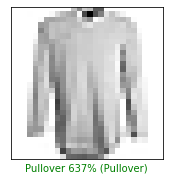

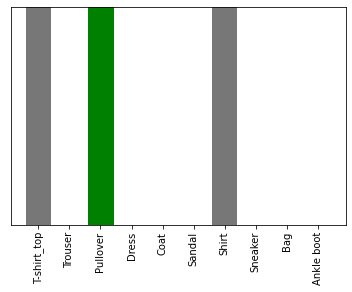

In [45]:
#@title Visualize the outputs { run: "auto" }
index = 46 #@param {type:"slider", min:1, max:50, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.show()
plot_value_array(index, predictions, test_labels)
plt.show()

# Download TFLite model and assets

**NOTE: You might have to run to the cell below twice**

In [46]:
try:
  from google.colab import files
  files.download(tflite_model_file)
  files.download('labels.txt')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Deploying TFLite model

Now once you've the trained TFLite model downloaded, you can ahead and deploy this on an Android/iOS application by placing the model assets in the appropriate location.

# Prepare the test images for download (Optional)

In [47]:
!mkdir -p test_images

In [48]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]].lower(), index))

In [49]:
!ls test_images

'ankle boot_11.jpg'   coat_42.jpg       sandal_48.jpg	 trouser_4.jpg
'ankle boot_49.jpg'   dress_44.jpg      shirt_10.jpg	 t-shirt_top_12.jpg
'ankle boot_5.jpg'    pullover_0.jpg    shirt_28.jpg	 t-shirt_top_18.jpg
 bag_20.jpg	      pullover_23.jpg   shirt_38.jpg	 t-shirt_top_21.jpg
 bag_2.jpg	      pullover_30.jpg   shirt_41.jpg	 t-shirt_top_24.jpg
 bag_34.jpg	      pullover_37.jpg   sneaker_13.jpg	 t-shirt_top_25.jpg
 coat_15.jpg	      pullover_46.jpg   sneaker_39.jpg	 t-shirt_top_32.jpg
 coat_16.jpg	      pullover_6.jpg    sneaker_47.jpg	 t-shirt_top_35.jpg
 coat_22.jpg	      pullover_7.jpg    trouser_17.jpg	 t-shirt_top_40.jpg
 coat_27.jpg	      pullover_9.jpg    trouser_1.jpg	 t-shirt_top_43.jpg
 coat_29.jpg	      sandal_14.jpg     trouser_26.jpg	 t-shirt_top_8.jpg
 coat_36.jpg	      sandal_19.jpg     trouser_33.jpg
 coat_3.jpg	      sandal_31.jpg     trouser_45.jpg


In [50]:
!zip -qq fmnist_test_images.zip -r test_images/

In [51]:
try:
  files.download('fmnist_test_images.zip')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>